In [33]:
import pymc
import numpy as np
import pandas as pd
import xarray as xr
import copy
import matplotlib.pyplot as plt
import pygemfxns_ensemble_sampling as es
import glob
import os
from pandas.plotting import autocorrelation_plot
import pygemfxns_ensemble_sampling as es
import matplotlib.mlab as mlab
from jupyterthemes import jtplot
from scipy.stats import gaussian_kde
import scipy.stats as stats 

jtplot.style('grade3', fscale=1.3)
jtplot.figsize(x=18, y=10)

In [24]:
def get_glacier_data(glacier_number):
            '''
            Returns the mass balance and error estimate for
            the glacier from David Shean's DEM data


            Parameters
            ----------
            glacier_number : float
                RGI Id of the glacier for which data is to be
                returned. Should be a number with a one or two
                digit component before the decimal place
                signifying glacier region, and 5 numbers after
                the decimal which represent glacier number.
                Example: 15.03733 for glacier 3733 in region 15


            Returns
            -------
            (tuple)
            massbal : float
                average annual massbalance over david sheans's
                dataset
            stdev : float
                estimate error (standard deviation) of measurement
            index : int
                index of glacier in csv file for debugging

            '''

            #convert input to float
            glacier_number = float(glacier_number)

            # upload csv file of DEM data and convert to 
            # dataframe
            csv_path = '../DEMs/hma_mb_20171211_1343.csv'
            df = pd.read_csv(csv_path)

            # locate the row corresponding to the glacier
            # with the given RGIId number
            row = df.loc[round(df['RGIId'], 5) == glacier_number]

            # get massbalance, measurement error (standard
            # deviation) and index of the 
            # glacier (index for debugging purposes)
            index = row.index[0]
            massbal = row['mb_mwea'][index]
            stdev = row['mb_mwea_sigma'][index]

            return massbal, stdev, index

In [27]:
mu, sigma, index = get_glacier_data(float('15.' + '03473'))
mu, sigma, index

(-0.54100000000000004, 0.24299999999999999, 1977)

In [ ]:
For glacier #15.03473

In [30]:
glac_map = {'2':'03473', '3':'10075', '5':'03733'}
traces = {}
glacs = []

for key, value in glac_map.items():
    
    glacs.append(value)
    
    traces[value] = {}

    filelist = glob.glob(os.path.join( 'test' + key + '*.pickle'))
    print(filelist)
    for f in filelist:
        sample = f[11:-7]
        print(sample)
        traces[value][sample] = pymc.database.pickle.load(f)

['test2length3000.pickle', 'test2length30000.pickle', 'test2length5000.pickle', 'test2length1000.pickle', 'test2length10000.pickle']
3000
30000
5000
1000
10000
['test3length1000.pickle', 'test3length500.pickle', 'test3length3000.pickle']
1000
500
3000
['test5length3000.pickle', 'test5length10000.pickle', 'test5length5000.pickle', 'test5length1000.pickle']
3000
10000
5000
1000


/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


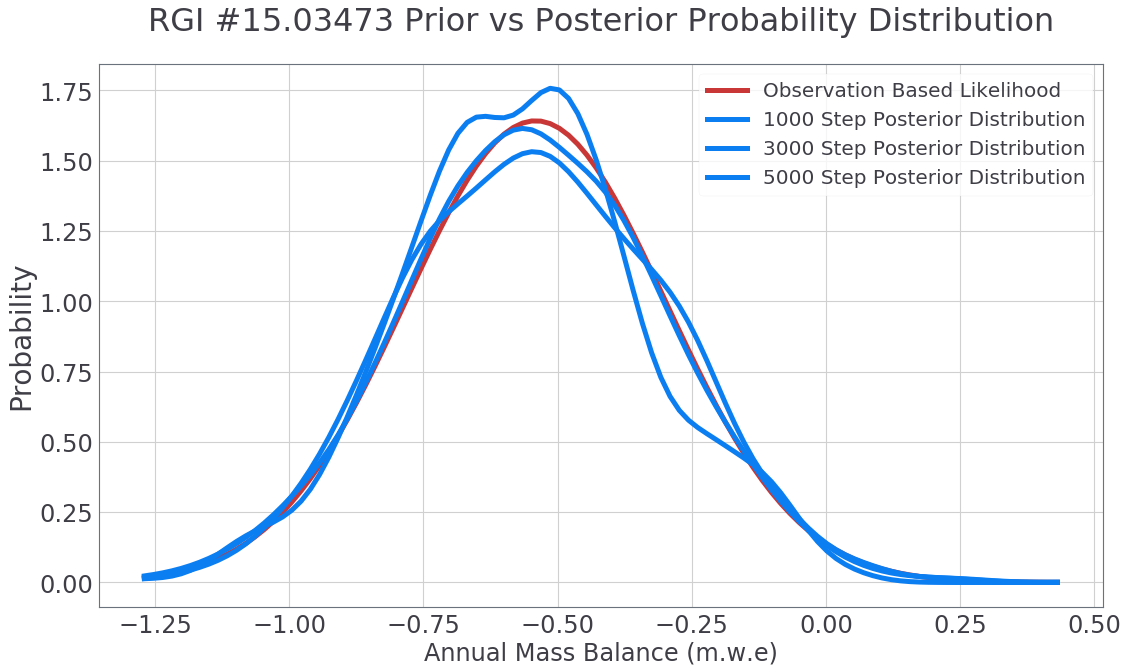

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


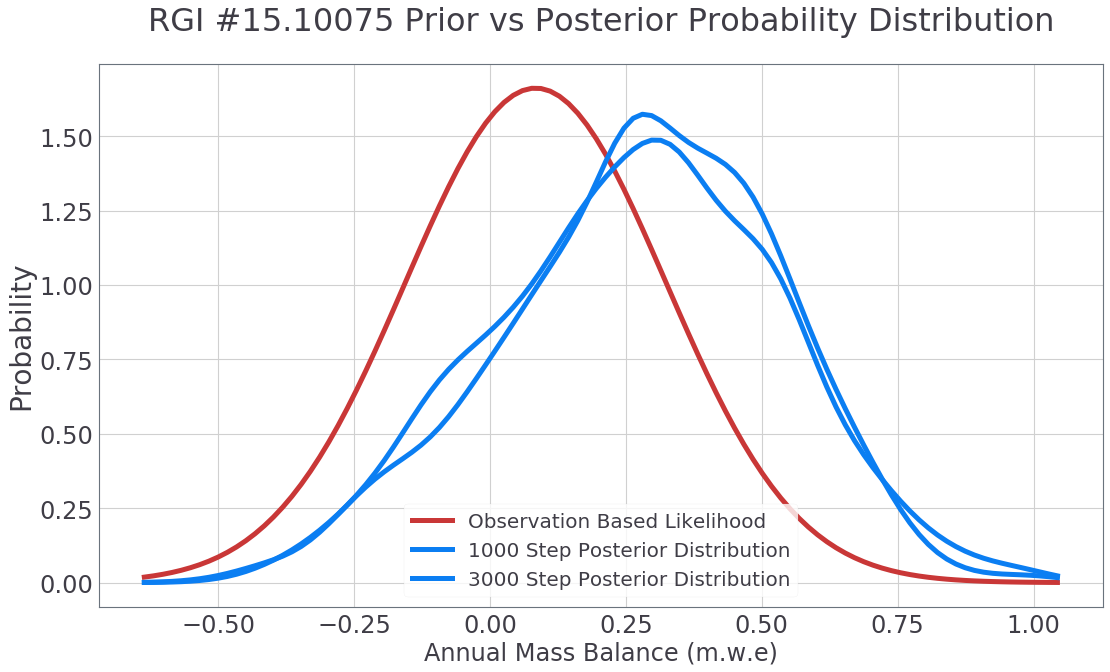

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


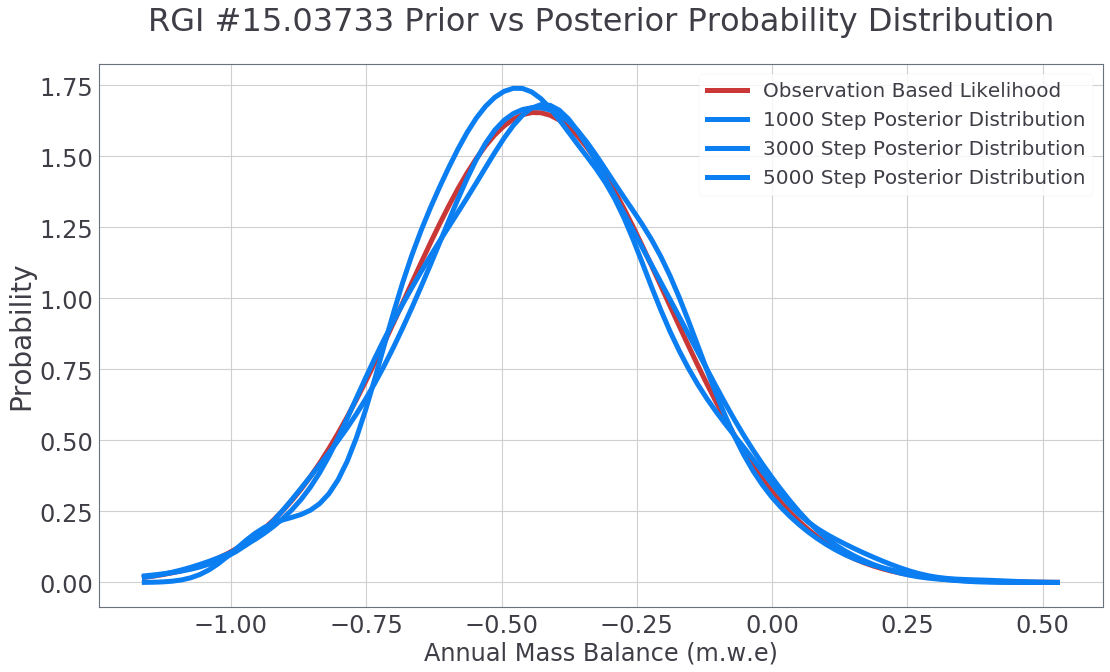

In [36]:
nums = ['10075', '10079', '10059', '10060']
params = {'tempchange':'Temperature Change', 'ddfsnow': 'DDF Snow', 'precfactor': 'Precipitation Factor'}
colors = [ '#C93737', '#0B7EF2', '#4C0099', '#CC6600']

for glac in glacs:
    
    if glac == '03473' or glac == '03733':
        
        samples = ['1000', '3000', '5000']
    
    elif glac == '10075' or glac == '10060':
        
        samples = ['1000', '3000']
        
    fig = plt.figure()

    #plot the observation        
    mu, sigma, index = get_glacier_data(float('15.' + glac))
    x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
    plt.plot(x,mlab.normpdf(x, mu, sigma), color=colors[0], label = 'Observation Based Likelihood', linewidth=5)
        
    for sample in samples:


        # plot the actual density distribution
        data = traces[glac][sample].trace('mass_bal')[:]
        density = gaussian_kde(data)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        plt.plot(x,density(x), label = sample + ' Step Posterior Distribution', color=colors[1], linewidth=5)


    # niceties
    plt.legend(loc='best', fontsize=20)

    plt.title('RGI #15.' + glac + ' Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
    plt.ylabel('Probability', fontsize =28)
    plt.xlabel('Annual Mass Balance (m.w.e)', fontsize = 24)

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    plt.show()

    #print('../probability_plots/' + num + key + '.png')

    #fig.savefig('../probability_plots/' + nums[i] + key + '.png')
